In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
import math
import os.path

import keras
import sklearn

import pandas
import numpy
from matplotlib import pyplot as plt

import urbansound8k
import preprocess
import train


In [15]:
data = urbansound8k.load_dataset()
data.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


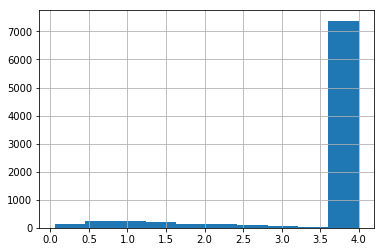

In [16]:
(data.end - data.start).hist()

In [17]:
(data.end-data.start).mode()

0    4.0
dtype: float64

In [18]:
folds, test = urbansound8k.folds(data)
len(folds), folds[0][0].shape, folds[0][1].shape, test.shape

(9, (7022, 8), (873, 8), (837, 8))

In [22]:
frame_samples=256
window_frames=72
fs=16000
w_ms = (frame_samples*window_frames/fs)
print('window size', w_ms)
w = list(train.sample_windows(int(4.0*fs), frame_samples=frame_samples, window_frames=window_frames))
print(w[-2][1] - w[-2][0], w[-1][1] - w[-1][0])
w

window size 1.152
17920.0 8704.0


[(0, 18432),
 (9216.0, 27648.0),
 (18432.0, 36864.0),
 (27648.0, 46080.0),
 (36864.0, 55296.0),
 (46080.0, 64000),
 (55296.0, 64000)]

cutting 7752 samples shorter than 1.0 seconds
37064


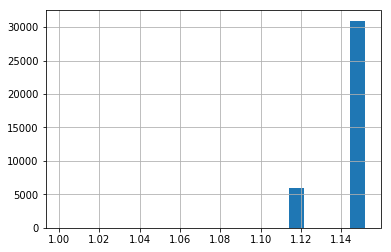

In [23]:
df = train.expand_training_set(folds[0][0], frame_samples=frame_samples, window_frames=window_frames)
print(len(df))
(df.end-df.start).hist(bins=20)  

In [47]:
settings = dict(
    feature='mels',
    samplerate=16000,
    n_mels=32,
    fmin=0,
    fmax=8000,
    n_fft=512,
    hop_length=256,
    augmentations=5,
)

def load_sample(sample):
    return train.load_sample(sample, settings, feature_dir='../../scratch/aug')
    
load_sample(df.iloc[5]).shape

(32, 72, 1)

In [48]:
gen = train.dataframe_generator

fold = df
import itertools
g = gen(fold[0:16], fold.classID[0:16], loader=load_sample, batchsize=8)
batches = list(itertools.islice(g, 16))
len(batches), batches[0][0].shape, batches[0][1].shape

(16, (8, 32, 72, 1), (8, 10))

In [49]:
import dense
import sbcnn
import dilated

def build_model():

    #model = dilated.build_model(bands=32, frames=72, channels=1, kernels=[32,32,32,32])
    model = sbcnn.build_model(bands=32, frames=72, channels=1, pool=(3,3))
    #model = dense.build_model(bands=32, frames=72, channels=1, pooling='avg',
    #                          dropout=0.5, growth=30, reduction=0.5)
    
    #model = dense.build_model(bands=32, frames=72, channels=1, pooling='avg',
    #                          dropout=0.5, growth=30, reduction=0.5)
    
    return model

build_model().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 32, 72, 24)        240       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 10, 24, 24)        0         
_________________________________________________________________
activation_56 (Activation)   (None, 10, 24, 24)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 24, 48)        10416     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 3, 8, 48)          0         
_________________________________________________________________
activation_57 (Activation)   (None, 3, 8, 48)          0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 1, 6, 48)          20784     
__________

In [52]:
os.makedirs('test')
h = train.train_model("test", folds[0],
                      builder=build_model, loader=load_sample,
                      frame_samples=frame_samples, window_frames=window_frames,
                      epochs=50, train_samples=35000, val_samples=3000, batch_size=100)

cutting 7752 samples shorter than 1.0 seconds
cutting 947 samples shorter than 1.0 seconds
dataset (37064, 6) (4655, 6)
Epoch 1/10
350/350 [==============================] - 60s 171ms/step - loss: 2.3293 - acc: 0.1859 - val_loss: 1.9140 - val_acc: 0.3350

Epoch 00001: saving model to test/e01-v1.91.model.hdf5
Epoch 2/10
350/350 [==============================] - 56s 161ms/step - loss: 1.9999 - acc: 0.2750 - val_loss: 1.6574 - val_acc: 0.4760

Epoch 00002: saving model to test/e02-v1.66.model.hdf5
Epoch 3/10
350/350 [==============================] - 57s 163ms/step - loss: 1.8515 - acc: 0.3301 - val_loss: 1.5897 - val_acc: 0.5753

Epoch 00003: saving model to test/e03-v1.59.model.hdf5
Epoch 4/10
350/350 [==============================] - 58s 167ms/step - loss: 1.7479 - acc: 0.3650 - val_loss: 1.4646 - val_acc: 0.5400

Epoch 00004: saving model to test/e04-v1.46.model.hdf5
Epoch 5/10
350/350 [==============================] - 58s 166ms/step - loss: 1.6679 - acc: 0.3933 - val_loss: 1.4355

In [42]:
h.epoch, h.history

([0],
 {'val_loss': [2.319274067878723],
  'val_acc': [0.05000000074505806],
  'loss': [2.384737968444824],
  'acc': [0.15000000223517418]})

In [43]:
train.history_dataframe(h)

,epoch,val_loss,val_acc,loss,acc
0,0,2.319274,0.05,2.384738,0.15


In [690]:
def run_experiment(name):
    
    for fold_no, fold_data in enumerate(folds):
        model_name = "{}.f{}".format(name, fold_no)
        hist = train_model(model_name, fold_data,
                           epochs=1, train_samples=20, val_samples=20, batch_size=10)
        df = history_dataframe(hist)
        df.to_csv(model_name+'.history.csv')

run_experiment("first")
        

KeyboardInterrupt: 

In [124]:
p = 'jobs/sbcnn.orig-2019-02-26-02-12-2c8ffebe-fold7/e10-v13.78.model.hdf5'
model = keras.models.load_model(p)
model

In [126]:
import collections

def predict_windowed(model, samples, method='mean'):
    sample_rate = settings['samplerate']
    Sample = collections.namedtuple('Sample', 'start end fold slice_file_name')

    out = []
    for _, sample in samples.iterrows():
        duration = sample.end - sample.start
        length = int(sample_rate * duration)
        windows = []
        
        for win in sample_windows(length, frame_samples, window_frames):
            chunk = Sample(start=win[0]/sample_rate,
                           end=win[1]/sample_rate,
                           fold=sample.fold,
                           slice_file_name=sample.slice_file_name)    
            d = load_sample(chunk)
            windows.append(d)

        inputs = numpy.stack(windows)
        predictions = model.predict(inputs)

        if method == 'mean':
            p = numpy.mean(predictions, axis=0)
            assert len(p) == 10
            out.append(numpy.argmax(p))
        elif method == 'majority':
            votes = numpy.argmax(predictions, axis=1)
            p = numpy.argmax(numpy.bincount(votes))
            out.append(p)

    return numpy.stack(out)

from sklearn.metrics import accuracy_score

t = test[0:10]
mean_m = predict_windowed(model, t, method='mean')
accuracy_score(t.classID, mean_m)

0.0

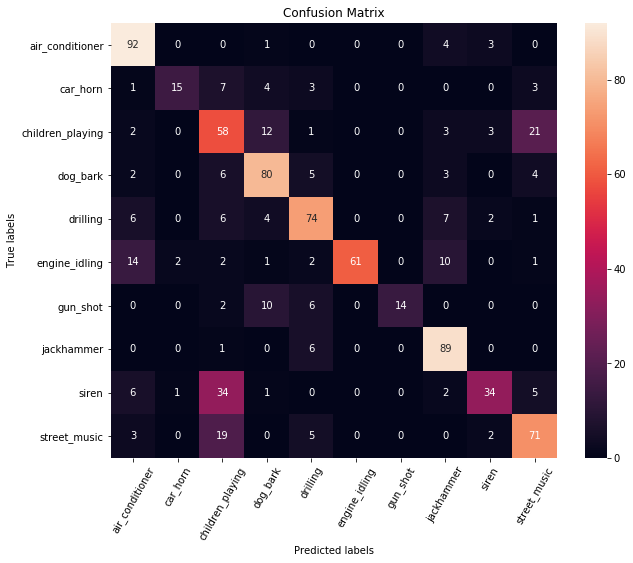

In [660]:
#import seaborn as sns
import matplotlib.pyplot as plt     

def plot_confusion(cm, classnames):

    fig, ax = plt.subplots(1, figsize=(10,8))
    sns.heatmap(cm, annot=True, ax=ax);

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix') 
    ax.xaxis.set_ticklabels(classnames, rotation=60)
    ax.yaxis.set_ticklabels(classnames, rotation=0)

from sklearn.metrics import confusion_matrix
#cm = confusion_matrix(val_d.classID, val_p, labels=None, sample_weight=None)
cm = confusion_matrix(t.classID, mean_m, labels=None, sample_weight=None)
plot_confusion(cm, urbansound8k.classnames)

fold
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

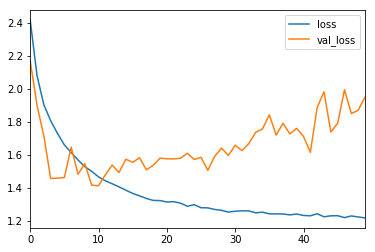

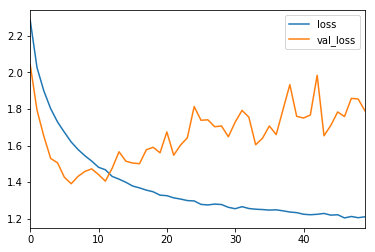

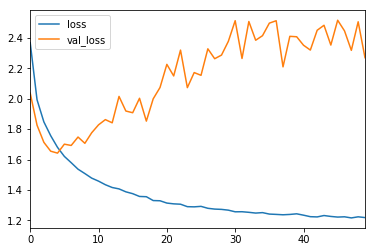

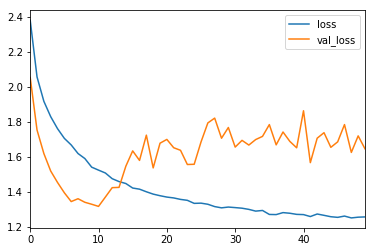

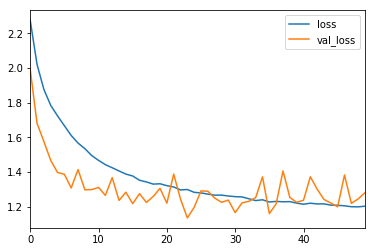

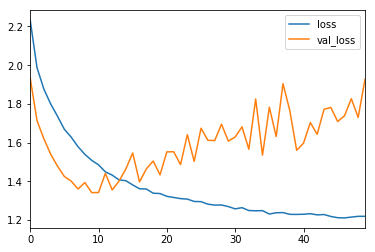

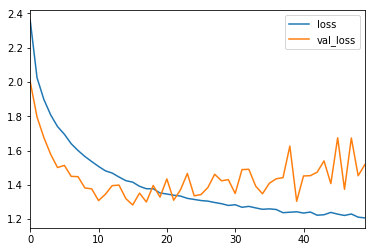

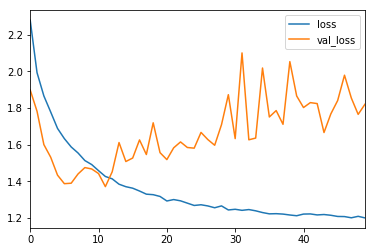

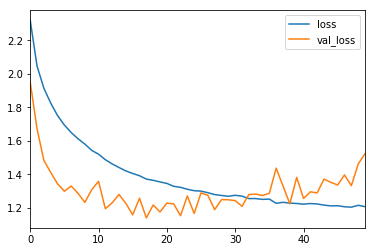

In [88]:
# jobs/sbcnn.orig-2019-02-26-13-56-26d5f8ac-fold8/history.csv


def load_history():
    jobs_dir = 'jobs'
    job_id = '2019-02-26-13-56-26d5f8a'
    
    matching = [ d for d in os.listdir(jobs_dir) if job_id in d ]

    dataframes = []
    
    for job_dir in matching:
        fold = job_dir.split('-fold')[1]
        hist_path = os.path.join(jobs_dir, job_dir, 'history.csv')
    
        df = pandas.read_csv(hist_path)
        del df['Unnamed: 0']
        df['epoch'] = df.epoch + 1
        df['fold'] = fold
        
        models = []
        for fname in os.listdir(os.path.join(jobs_dir, job_dir)):
            if fname.endswith('model.hdf5'):
                models.append(fname)
        
        models = sorted(models)
        assert models[0].startswith('e01')
        assert models[len(models)-1].startswith('e{:0d}'.format(len(models)))
        df['model'] = [ os.path.join(jobs_dir, job_dir, m) for m in models ]
        dataframes.append(df)

    df = pandas.concat(dataframes)
    return df

df = load_history()

df.groupby('fold').plot(y=['loss', 'val_loss'])

fold
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

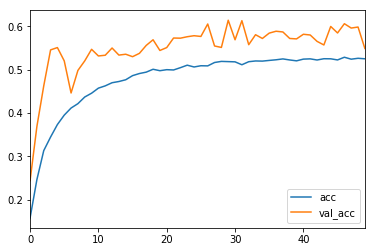

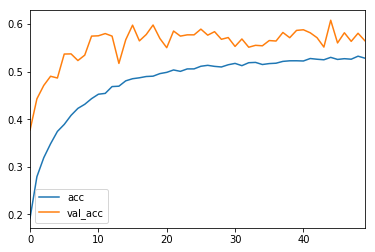

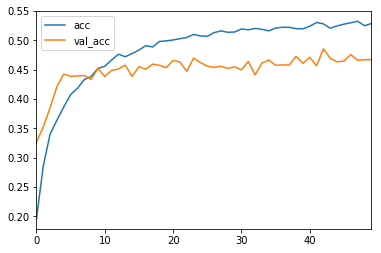

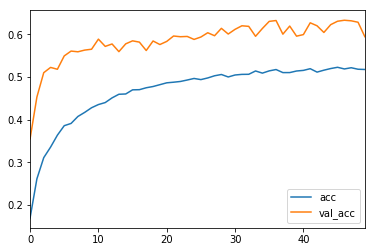

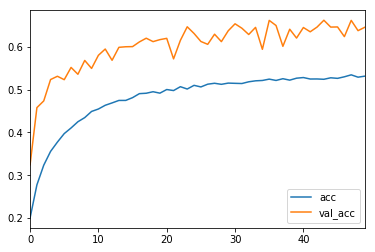

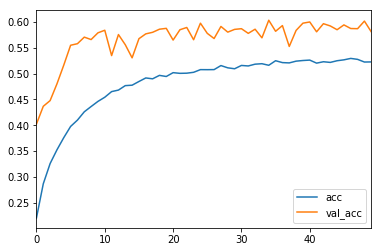

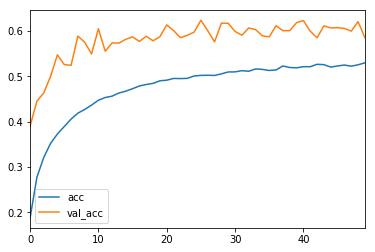

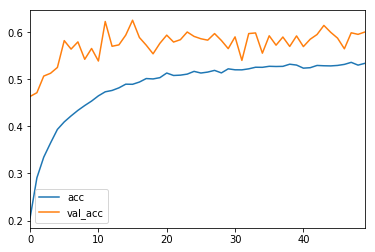

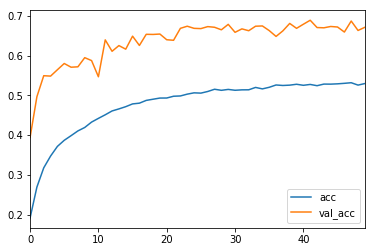

In [87]:
df.groupby('fold').plot(y=['acc', 'val_acc'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac5c106cc0>],
      dtype=object)

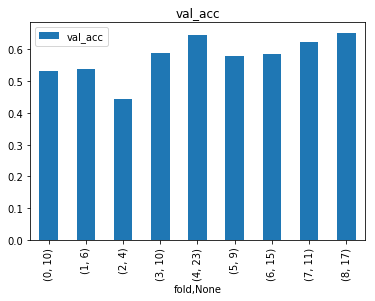

In [109]:
best_by_loss = df.groupby('fold').apply(lambda d: d.sort_values('val_loss', ascending=True).head(1))
best_by_loss.plot(y='val_acc', kind='bar', subplots=True)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fac5c1aada0>],
      dtype=object)

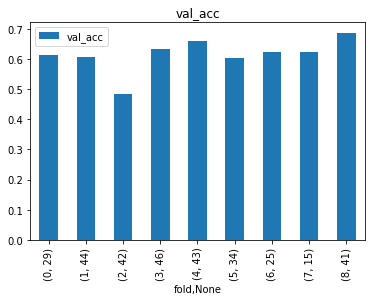

In [108]:
best_by_acc = df.groupby('fold').apply(lambda d: d.sort_values('val_acc', ascending=False).head(1))
best_by_acc.plot(y='val_acc', kind='bar', subplots=True)

In [119]:
# Takes 30 seconds
models = best_by_loss['model'].apply(lambda p: keras.models.load_model(p))


In [135]:
def score(model, data):
    predictions = predict_windowed(model, data, method='mean')
    s = accuracy_score(data.classID, predictions)
    print('acc', s)
    return s

scores = [ score(m, test) for m in models ]

acc 0.6547192353643967
acc 0.6391875746714456
acc 0.6463560334528077
acc 0.6571087216248507
acc 0.6642771804062126
acc 0.7431302270011948
acc 0.6511350059737157
acc 0.7120669056152927
acc 0.6403823178016727


(0.6, 0.85)

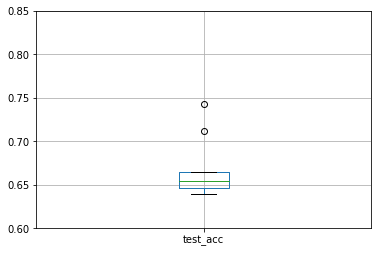

In [136]:
ax = pandas.DataFrame({'test_acc': scores }).boxplot()
ax.set_ylim((0.6, 0.85))